In [1]:
import time
notebookstart= time.time()

In [2]:
import os
from typing import Tuple, Optional

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
DIR_DATA = os.path.join(os.getcwd(), 'data')
DIR_SUBM = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_TRAIN = os.path.join(os.getcwd(), 'subm', 'train')
DIR_DATA_TRAIN = os.path.join(DIR_DATA, 'train')
DIR_DATA_TEST  = os.path.join(DIR_DATA, 'test')

In [4]:
!pip install catboost

In [5]:
from catboost import CatBoostRegressor
from catboost import Pool, cv

In [6]:
train_df = pd.read_csv(os.path.join(DIR_DATA, 'train_upd.csv'))
test_df  = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'))
train_df.shape, test_df.shape

((530, 16), (521, 15))

In [7]:
train_df.head()

,image_name,distance,x_min,y_min,x_max,y_max,conf,class,h,w,log_x_min,log_y_min,log_x_max,log_y_max,log_h,log_w
0,img_1596.jpg,4.88,1661.424072,1172.543701,2280.588135,1717.848145,0.860831,2.0,545.304443,619.164062,7.415430,7.066931,7.732189,7.448828,6.301344,6.428370
1,img_1600.jpg,1.54,1125.089722,1185.073486,3012.445312,2716.680420,0.853032,2.0,1531.606934,1887.355591,7.025618,7.077560,8.010507,7.907166,7.334073,7.542932
2,img_1601.jpg,3.68,2442.252441,1335.316040,3050.830566,1787.521118,0.891922,2.0,452.205078,608.578125,7.800676,7.196923,8.023169,7.488585,6.114136,6.411125
3,img_1603.jpg,2.22,2602.999512,1277.598389,3310.421875,1849.868042,0.779553,2.0,572.269653,707.422363,7.864420,7.152737,8.104831,7.522870,6.349610,6.561628
4,img_1605.jpg,3.73,2487.154053,1227.636475,3107.961426,1682.682129,0.909514,2.0,455.045654,620.807373,7.818894,7.112846,8.041722,7.428144,6.120398,6.431021


In [8]:
train_df['class'].value_counts()

2.0    528
0.0      1
Name: class, dtype: int64

In [9]:
def plot_feature_importance(importance, names, model_type, imp_number: Optional[int] = 30):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'][:imp_number], y=fi_df['feature_names'][:imp_number])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [10]:
motion_blur_train = set(['img_2709.heic', 'img_2733.heic', 'img_2734.heic'])    # 'img_2734.heic' возможно рабочий 
print(train_df.shape)

for el in train_df.index:
    if train_df.loc[el, 'image_name'] in motion_blur_train:
        train_df.drop(el, inplace = True)

print(train_df.shape)

(530, 16)
(527, 16)


In [11]:
%%time
params = {"iterations": 3500,
          "loss_function": 'RMSE',
          #"loss_function": 'R2',
         }

features = ['x_min', 'y_min', 'x_max', 'y_max', 'conf', 'h', 'w']
#features = ['log_x_min', 'log_y_min', 'log_x_max', 'log_y_max', 'conf', 'log_h', 'log_w']

train = Pool(data = train_df[features],
             label = train_df[['distance']],
             #cat_features=cat_features
            )

scores = cv(train, params,
            fold_count = 3,
            verbose = False,
           )

Training on fold [0/3]

bestTest = 0.8406931708
bestIteration = 574

Training on fold [1/3]

bestTest = 0.8459063947
bestIteration = 292

Training on fold [2/3]

bestTest = 0.7964546462
bestIteration = 1226

CPU times: total: 1min 27s
Wall time: 16.5 s


In [12]:
niter = scores['test-RMSE-mean'].argmin() + 13
scores['test-RMSE-mean'].min(), scores['test-RMSE-mean'].argmin(), niter

(0.8325268178372949, 652, 665)

In [13]:
%%time

model_cb = CatBoostRegressor(iterations = niter, verbose = 100)
#model_cb = CatBoostRegressor(verbose = 100)

# Fit model
model_cb.fit(train_df[features], train_df[['distance']].values)

Learning rate set to 0.051555
0:	learn: 1.7060347	total: 4ms	remaining: 2.65s
100:	learn: 0.6241534	total: 157ms	remaining: 876ms
200:	learn: 0.4878836	total: 272ms	remaining: 627ms
300:	learn: 0.4106621	total: 390ms	remaining: 471ms
400:	learn: 0.3489283	total: 505ms	remaining: 332ms
500:	learn: 0.2994362	total: 703ms	remaining: 230ms
600:	learn: 0.2602086	total: 833ms	remaining: 88.7ms
664:	learn: 0.2387402	total: 905ms	remaining: 0us
CPU times: total: 4.86 s
Wall time: 1.43 s


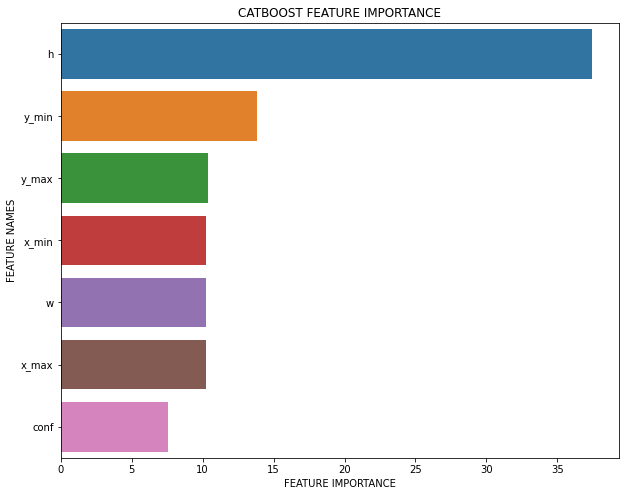

In [14]:
#plot_feature_importance(model_cb.get_feature_importance(), train_df[features].get_feature_names(), 'CATBOOST')
plot_feature_importance(model_cb.get_feature_importance(), features, 'CATBOOST')

In [15]:
pred_train = model_cb.predict(train_df[features])
train_df['pred'] = pred_train
train_df.to_csv(os.path.join(DIR_SUBM_TRAIN, 'train_with_pred.csv'), index = False)

In [16]:
preds = model_cb.predict(test_df[features])
test_df['distance'] = preds

sample_solution_df = test_df[['image_name', 'distance']]

In [17]:
test_img_names = set(os.listdir(DIR_DATA_TEST))

In [18]:
lost_test_items = []

for file_name in test_img_names - set(sample_solution_df['image_name'].values):
    lost_test_items.append([file_name, 0])
    
lost_test_items_df = pd.DataFrame(lost_test_items, columns=['image_name', 'distance'])
sample_solution_df = pd.concat([sample_solution_df, lost_test_items_df])

#sample_solution_df.to_csv(os.path.join(DIR_SUBM, '16_yolo5l_minhw_cntr_niter_nomb.csv'), sep=';', index=False)
sample_solution_df.to_csv(os.path.join(DIR_SUBM, '16_mp.csv'), sep=';', index=False)